# Homework Assignment 7

In [1]:
from collections import Counter
import networkx as nx
from tqdm import tqdm


import spacy
# !python -m spacy download en_core_web_lg
nlp = spacy.load('en_core_web_lg')

In [ ]:
!pip install turicreate

In [ ]:
!pip install afinn

In [3]:
import nltk
nltk.download('punkt')

from nltk.tokenize import word_tokenize
import turicreate as tc
import pandas as pd

import seaborn as sns
sns.set()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


**Question 1:** Select two books and construct networks of people and locations, i.e. each link is between a a person and a location (20pt). Visualize the network using Cytoscape or Gephi (20pt).


First book is: Oliver Twist by Charles Dickens's


In [4]:
# mount drive for cytoscape images
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# create directories
!mkdir ./datasets
!mkdir ./datasets/books
!mkdir ./datasets/books/oliver

# download dataset txt file
!wget https://www.gutenberg.org/files/730/730-0.txt -O ./datasets/books/oliver/oliver.txt

In [6]:
# create set of tuples of persons and locations
def get_person_location_links(txt):
    links_set = set()
    doc = nlp(txt)
    persons = [entity.text.lower().strip() for entity in doc.ents if entity.label_ == "PERSON"]
    locations = [entity.text.lower().strip().replace('\n', ' ') for entity in doc.ents if entity.label_ == "LOC"]
    
    for e1 in persons:
        for e2 in locations:
            if len(e1) < 2 or len(e2) < 2:
                continue
            if e1 > e2:
                e1, e2 = e2, e1 # switch order
            links_set.add((e1, e2))

    return links_set

In [7]:
# split text to paragrahps
oliver_path = './datasets/books/oliver/oliver.txt'
txt = open(oliver_path).read()
paragraphs_list = txt.split("\n\n")

# find the index of the first chapter
for index, para in enumerate(paragraphs_list):
  if 'CHAPTER I.' in para.strip():
    first_chap = index
    break

# find the index of the last chapter
for index, para in enumerate(paragraphs_list):
  if '*** END OF THE PROJECT GUTENBERG EBOOK' in para:
    last_chap = index-1
    break

In [8]:
links_list = []    
for index in tqdm(range(first_chap, last_chap+1)):
    if len(paragraphs_list[index]) > 0:
      # for each paragraph each link counts only once
      links_list += list(get_person_location_links(paragraphs_list[index]))

100%|██████████| 3946/3946 [01:12<00:00, 54.11it/s]


In [9]:
# build graph with the given links (links between persons and locations)
def build_graph(links):
  g = nx.Graph()
  c = Counter(links)

  for e, count in dict(c).items():
      v1,v2 = e
      g.add_edge(v1,v2, weight=count)

  print(nx.info(g))
  return g

g = build_graph(links_list)

Graph with 59 nodes and 54 edges


In [10]:
# save graph as .gml to use it on cytoscape software
def save_graph(g, path):
  nx.write_gml(g, path)

save_graph(g, './datasets/books/oliver/oliver_network.gml')

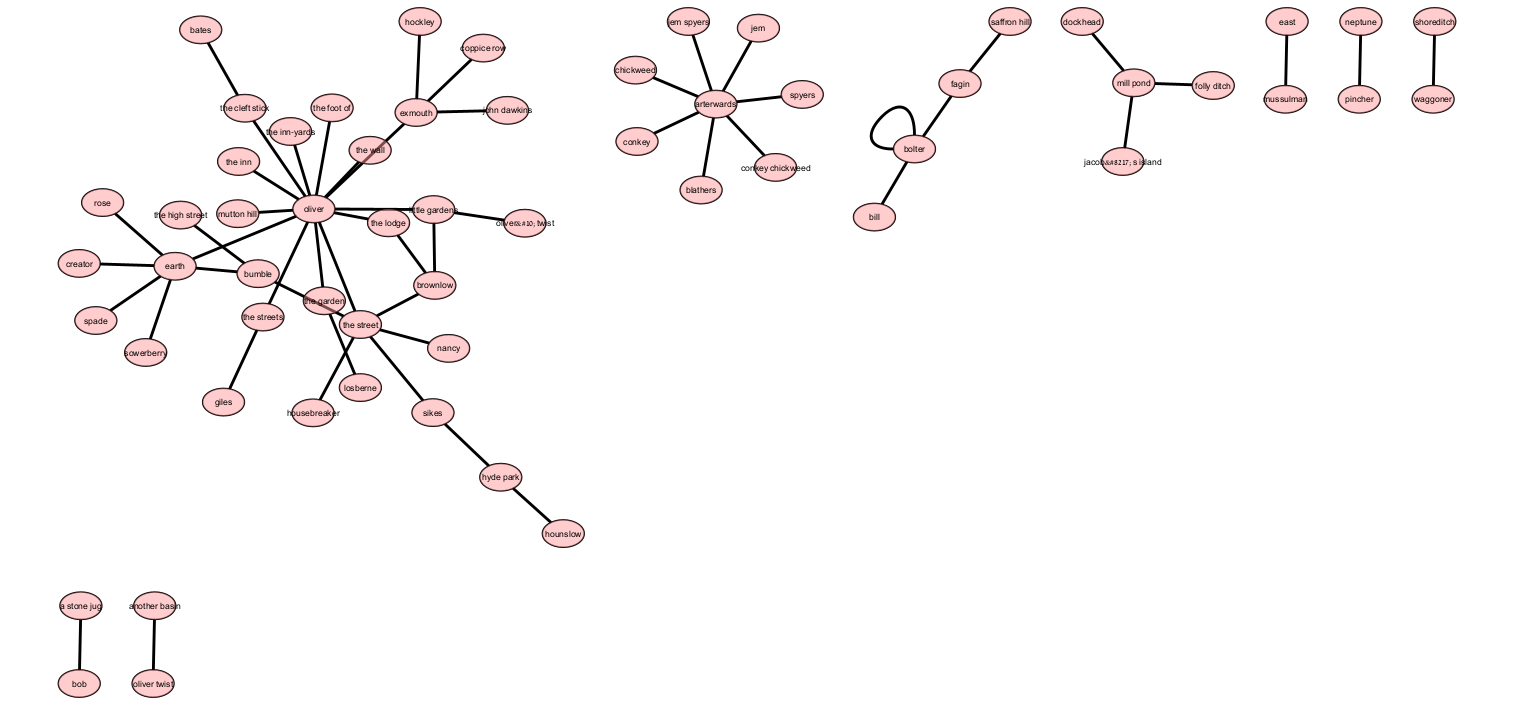

In [11]:
# Cytoscape
from IPython.display import Image
Image('/content/drive/MyDrive/BigData_Course/oliver_network_cytoscape.png')

Alice's Adventures in Wonderland by Lewis Carroll

In [ ]:
# create dataset directory and download txt file
!mkdir ./datasets/books/alice
!wget https://www.gutenberg.org/files/11/11-0.txt -O ./datasets/books/alice/alice.txt

In [13]:
alice_path = './datasets/books/alice/alice.txt'

In [14]:
# split text to paragrahps
txt_alice = open(alice_path).read()
paragraphs_list_alice = txt_alice.split("\n\n")

# find the index of the first chapter
for index, para in enumerate(paragraphs_list_alice):
  if 'CHAPTER I.Down the Rabbit-Hole' == para.replace('\n', ''):
    first_chap = index
    break

# find the index of the last chapter
for index, para in enumerate(paragraphs_list_alice):
  if 'END OF THE PROJECT GUTENBERG EBOOK' in para:
    last_chap = index-1
    break

In [21]:
links_list_alice = []    
for index in tqdm(range(first_chap, last_chap+1)):
    if len(paragraphs_list_alice[index]) > 0:
      # for each paragraph each link counts only once
      links_list_alice += list(get_person_location_links(paragraphs_list_alice[index]))

100%|██████████| 823/823 [00:14<00:00, 58.57it/s]


In [23]:
g = build_graph(links_list_alice)
save_graph(g, './datasets/books/alice/alice_network.gml')

Graph with 9 nodes and 8 edges


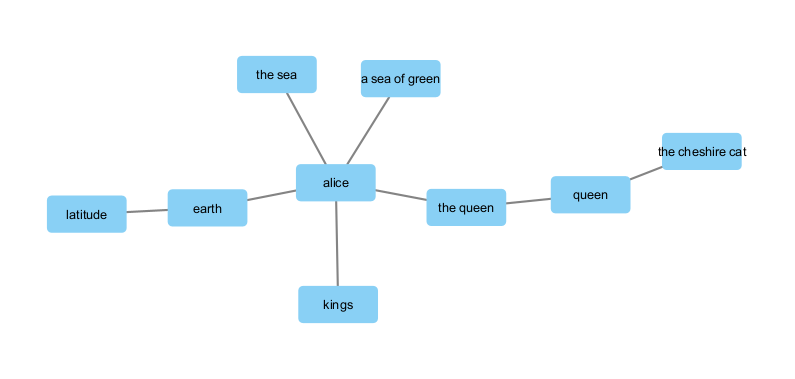

In [24]:
# Cytoscape
from IPython.display import Image
Image('/content/drive/MyDrive/BigData_Course/alice_network_cytoscape.png')

**Question 2:** Use the [Friends TV Show Transcript](https://www.kaggle.com/ryanstonebraker/friends-transcript)
to create and evaluate a classifier that given a line of text can predict
 who is the "friend" that said it (20pt). Using sentiment analysis identify who are the most and less friendly friends (20pt). Construct a classifier that can be given several text lines (quotes) from a specific episode that will predict the episode's season number (20pt).

In [ ]:
import json
import os

!mkdir /root/.kaggle/

# Installing the Kaggle package
api_token = {"username":"amitdamri","key":"a076ad6676498fde930f6aacbda924c4"}

# creating kaggle.json file with the personal API-Key details 
with open('/root/.kaggle/kaggle.json', 'w') as file:
  json.dump(api_token, file)
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
import kaggle

# create directories
!mkdir ./datasets
!mkdir ./datasets/friends

# download dataset from kaggle
!kaggle datasets download -d ryanstonebraker/friends-transcript -p ./datasets/friends
!unzip ./datasets/friends/*.zip -d ./datasets/friends

A classifier that given a line of text can predict who is the "friend" that said it

In [27]:
# load dataset into dataframe
df = pd.read_csv('./datasets/friends/friends_quotes.csv')
df

,author,episode_number,episode_title,quote,quote_order,season
0,Monica,1.0,Monica Gets A Roommate,There's nothing to tell! He's just some guy I ...,0.0,1.0
1,Joey,1.0,Monica Gets A Roommate,"C'mon, you're going out with the guy! There's ...",1.0,1.0
2,Chandler,1.0,Monica Gets A Roommate,"All right Joey, be nice. So does he have a hum...",2.0,1.0
3,Phoebe,1.0,Monica Gets A Roommate,"Wait, does he eat chalk?",3.0,1.0
4,Phoebe,1.0,Monica Gets A Roommate,"Just, 'cause, I don't want her to go through w...",4.0,1.0
...,...,...,...,...,...,...
60286,Chandler,17.0,"The Last One, Part I & II","Oh, it's gonna be okay.",581.0,10.0
60287,Rachel,17.0,"The Last One, Part I & II",(crying) Do you guys have to go to the new hou...,582.0,10.0
60288,Monica,17.0,"The Last One, Part I & II",We got some time.,583.0,10.0
60289,Rachel,17.0,"The Last One, Part I & II","Okay, should we get some coffee?",584.0,10.0


In [28]:
# dictionary of the "friends" only and their colors
friends_authors = {'ross':'g', 'rachel':'y', 'phoebe':'b', 'monica':'r', 'chandler':'w', 'joey':'k'}

In [29]:
# get only the author and quote columns
sf = tc.SFrame(df[['author', 'quote']])
# lower all author names
sf['author'] = sf['author'].apply(lambda author: author.lower())
sf.materialize()
# get only the "friends" authors
sf = sf.filter_by(friends_authors.keys(), 'author')
# count chars and words
sf['Chars Number'] = sf['quote'].apply(lambda s: len(s))
sf['Words Number'] = sf['quote'].apply(lambda s: len(word_tokenize(s)))
sf

author,quote,Chars Number,Words Number
monica,There's nothing to tell!He's just some guy I ...,56,15
joey,"C'mon, you're going outwith the guy! There's ...",80,20
chandler,"All right Joey, be nice.So does he have a hum ...",72,20
phoebe,"Wait, does he eat chalk?",24,7
phoebe,"Just, 'cause, I don'twant her to go through ...",79,20
monica,"Okay, everybody relax.This is not even a date. ...",109,26
chandler,Sounds like a date to me.,25,7
chandler,"Alright, so I'm back inhigh school, I'm stan ...",115,28
chandler,"Then I look down, and Irealize there's a ...",57,15
joey,Instead of...?,14,4


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

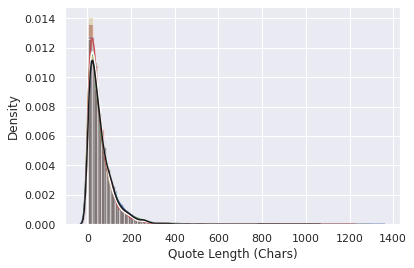

In [30]:
# distribution plot of number of chars for each author
for friend, color in friends_authors.items():
  sns.distplot(sf[sf['author'] == friend]['Chars Number'], axlabel="Quote Length (Chars)", color=color)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

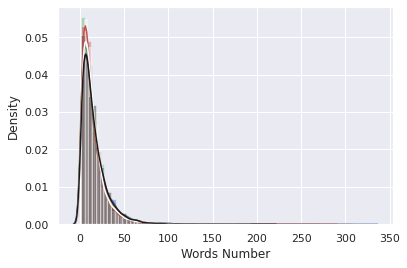

In [31]:
# distribution plot of number of words for each author
for friend, color in friends_authors.items():
  sns.distplot(sf[sf['author'] == friend]['Words Number'], axlabel="Words Number", color=color)

In [32]:
# lower all quotes
sf['qoute'] = sf['quote'].apply(lambda s: s.lower())
# bow
sf['bow'] = tc.text_analytics.count_words(sf['quote'])
sf['bow'] = sf['bow'].dict_trim_by_keys(tc.text_analytics.stop_words(lang='en'), exclude=True)
# 2 grams
sf['word_2gram'] = tc.text_analytics.count_ngrams(sf['quote'], n=2)
# embedding
vectors = []
for s in sf['qoute']:
    vectors.append(nlp(s).vector)
sf['vector'] = vectors

sf.materialize()
sf

author,quote,Chars Number,Words Number,qoute
monica,There's nothing to tell!He's just some guy I ...,56,15,there's nothing to tell!he's just some guy i ...
joey,"C'mon, you're going outwith the guy! There's ...",80,20,"c'mon, you're going outwith the guy! there's ..."
chandler,"All right Joey, be nice.So does he have a hum ...",72,20,"all right joey, be nice.so does he have a hum ..."
phoebe,"Wait, does he eat chalk?",24,7,"wait, does he eat chalk?"
phoebe,"Just, 'cause, I don'twant her to go through ...",79,20,"just, 'cause, i don'twant her to go through ..."
monica,"Okay, everybody relax.This is not even a date. ...",109,26,"okay, everybody relax.this is not even a date. ..."
chandler,Sounds like a date to me.,25,7,sounds like a date to me.
chandler,"Alright, so I'm back inhigh school, I'm stan ...",115,28,"alright, so i'm back inhigh school, i'm stan ..."
chandler,"Then I look down, and Irealize there's a ...",57,15,"then i look down, and irealize there's a ..."
joey,Instead of...?,14,4,instead of...?


In [33]:
train,test = sf.random_split(0.8)
cls = tc.classifier.create(train, features=['bow', 'word_2gram', 'vector'	,'Chars Number'], target='author')

PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.

PROGRESS: The following methods are available for this type of problem.
PROGRESS: BoostedTreesClassifier, RandomForestClassifier, DecisionTreeClassifier, LogisticClassifier
PROGRESS: The returned model will be chosen according to validation accuracy.


Boosted trees classifier:

--------------------------------------------------------

Number of examples          : 37732

Number of classes           : 6

Number of feature columns   : 4

Number of unpacked features : 139201

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training Accuracy | Validation Accuracy | Training Log Loss | Validation Log Loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 7.447963     | 0.265663          | 0.233635            | 1.760960          | 1.776343            |

| 2         | 13.957326    | 0.295982          | 0.246727            | 1.736904          | 1.761821            |

| 3         | 20.342538    | 0.316469          | 0.246727            | 1.715685          | 1.752980            |

| 4         | 26.986208    | 0.332662          | 0.256294            | 1.696288          | 1.746066            |

| 5         | 33.474337    | 0.347636          | 0.260826            | 1.680118          | 1.740922            |

| 7         | 46.046968    | 0.371038          | 0.271903            | 1.651319          | 1.728985            |

| 8         | 51.923879    | 0.380234          | 0.268882            | 1.640247          | 1.725866            |

| 9         | 58.158569    | 0.390623          | 0.274421            | 1.627703          | 1.722066            |

| 10        | 64.158864    | 0.398998          | 0.278449            | 1.617955          | 1.718796            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

Random forest classifier:

--------------------------------------------------------

Number of examples          : 37732

Number of classes           : 6

Number of feature columns   : 4

Number of unpacked features : 139201

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training Accuracy | Validation Accuracy | Training Log Loss | Validation Log Loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 4.962872     | 0.267227          | 0.235650            | 1.717567          | 1.760250            |

| 2         | 10.132874    | 0.285381          | 0.244713            | 1.711755          | 1.748371            |

| 3         | 15.293689    | 0.291715          | 0.251762            | 1.707609          | 1.748641            |

| 4         | 20.433837    | 0.298977          | 0.253776            | 1.706874          | 1.750182            |

| 5         | 25.392290    | 0.305152          | 0.252769            | 1.705916          | 1.748993            |

| 7         | 35.584166    | 0.309631          | 0.259315            | 1.705608          | 1.746600            |

| 8         | 40.562926    | 0.313023          | 0.252769            | 1.705266          | 1.746667            |

| 9         | 45.506712    | 0.313766          | 0.254784            | 1.704749          | 1.746269            |

| 10        | 50.582271    | 0.316045          | 0.261329            | 1.704370          | 1.744129            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

Decision tree classifier:

--------------------------------------------------------

Number of examples          : 37732

Number of classes           : 6

Number of feature columns   : 4

Number of unpacked features : 139201

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training Accuracy | Validation Accuracy | Training Log Loss | Validation Log Loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 6.058109     | 0.265663          | 0.233635            | 1.713975          | 1.764806            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

Logistic regression:

--------------------------------------------------------

Number of examples          : 37732

Number of classes           : 6

Number of feature columns   : 4

Number of unpacked features : 139201

Number of coefficients      : 696010

Starting L-BFGS

--------------------------------------------------------

+-----------+----------+-----------+--------------+-------------------+---------------------+

| Iteration | Passes   | Step size | Elapsed Time | Training Accuracy | Validation Accuracy |

+-----------+----------+-----------+--------------+-------------------+---------------------+

| 0         | 2        | 1.000000  | 2.816002     | 0.542510          | 0.232628            |

| 1         | 4        | 1.000000  | 98.222362    | 0.652311          | 0.266868            |

| 2         | 10       | 3.165394  | 199.141242   | 0.737597          | 0.267372            |

| 3         | 13       | 2.491082  | 298.764318   | 0.789357          | 0.294058            |

| 4         | 14       | 2.491082  | 395.533425   | 0.801256          | 0.284491            |

| 6         | 18       | 1.596040  | 585.725068   | 0.817502          | 0.290030            |

| 7         | 19       | 1.596040  | 682.393553   | 0.835286          | 0.290030            |

| 8         | 20       | 1.596040  | 781.569507   | 0.840136          | 0.296576            |

| 9         | 21       | 1.596040  | 882.523786   | 0.846735          | 0.284995            |

+-----------+----------+-----------+--------------+-------------------+---------------------+

PROGRESS: Model selection based on validation accuracy:
PROGRESS: ---------------------------------------------
PROGRESS: BoostedTreesClassifier          : 0.27844914400805637
PROGRESS: RandomForestClassifier          : 0.26132930513595165
PROGRESS: DecisionTreeClassifier          : 0.23363544813695872
PROGRESS: LogisticClassifier              : 0.2849949647532729
PROGRESS: ---------------------------------------------
PROGRESS: Selecting LogisticClassifier based on validation set performance.


In [34]:
cls.evaluate(test)

{'accuracy': 0.296689824274622,
 'auc': 0.6249212795098147,
 'confusion_matrix': Columns:
 	target_label	str
 	predicted_label	str
 	count	int
 
 Rows: 36
 
 Data:
 +--------------+-----------------+-------+
 | target_label | predicted_label | count |
 +--------------+-----------------+-------+
 |    rachel    |       ross      |  319  |
 |    phoebe    |       ross      |  196  |
 |   chandler   |       ross      |  295  |
 |   chandler   |      rachel     |  238  |
 |     ross     |      phoebe     |  174  |
 |    phoebe    |       joey      |  206  |
 |     joey     |      phoebe     |  166  |
 |     ross     |      rachel     |  261  |
 |    monica    |      phoebe     |  208  |
 |     joey     |     chandler    |  201  |
 +--------------+-----------------+-------+
 [36 rows x 3 columns]
 Note: Only the head of the SFrame is printed.
 You can use print_rows(num_rows=m, num_columns=n) to print more rows and columns.,
 'f1_score': 0.29371600601868386,
 'log_loss': 3.598003871191467,


**Using sentiment analysis to identify who are the most and less friendly friends**

In [35]:
from afinn import Afinn

afinn = Afinn()
# calc affin score for every quote
sf['afinn_score'] = sf['qoute'].apply(lambda t: afinn.score(t))
sf

author,quote,Chars Number,Words Number,qoute
monica,There's nothing to tell!He's just some guy I ...,56,15,there's nothing to tell!he's just some guy i ...
joey,"C'mon, you're going outwith the guy! There's ...",80,20,"c'mon, you're going outwith the guy! there's ..."
chandler,"All right Joey, be nice.So does he have a hum ...",72,20,"all right joey, be nice.so does he have a hum ..."
phoebe,"Wait, does he eat chalk?",24,7,"wait, does he eat chalk?"
phoebe,"Just, 'cause, I don'twant her to go through ...",79,20,"just, 'cause, i don'twant her to go through ..."
monica,"Okay, everybody relax.This is not even a date. ...",109,26,"okay, everybody relax.this is not even a date. ..."
chandler,Sounds like a date to me.,25,7,sounds like a date to me.
chandler,"Alright, so I'm back inhigh school, I'm stan ...",115,28,"alright, so i'm back inhigh school, i'm stan ..."
chandler,"Then I look down, and Irealize there's a ...",57,15,"then i look down, and irealize there's a ..."
joey,Instead of...?,14,4,instead of...?


In [36]:
from textblob import TextBlob
# calc textblob score for every qoute
sf['textblob_score'] = sf['qoute'].apply(lambda t: TextBlob(t).sentiment.polarity)
sf

author,quote,Chars Number,Words Number,qoute
monica,There's nothing to tell!He's just some guy I ...,56,15,there's nothing to tell!he's just some guy i ...
joey,"C'mon, you're going outwith the guy! There's ...",80,20,"c'mon, you're going outwith the guy! there's ..."
chandler,"All right Joey, be nice.So does he have a hum ...",72,20,"all right joey, be nice.so does he have a hum ..."
phoebe,"Wait, does he eat chalk?",24,7,"wait, does he eat chalk?"
phoebe,"Just, 'cause, I don'twant her to go through ...",79,20,"just, 'cause, i don'twant her to go through ..."
monica,"Okay, everybody relax.This is not even a date. ...",109,26,"okay, everybody relax.this is not even a date. ..."
chandler,Sounds like a date to me.,25,7,sounds like a date to me.
chandler,"Alright, so I'm back inhigh school, I'm stan ...",115,28,"alright, so i'm back inhigh school, i'm stan ..."
chandler,"Then I look down, and Irealize there's a ...",57,15,"then i look down, and irealize there's a ..."
joey,Instead of...?,14,4,instead of...?


In [37]:
sf.materialize()

In [38]:
def get_sentiment(row):
  # calc the avg of both of the measures
  row_sentiment = (row['textblob_score'] + row['afinn_score']) / 2
  # if the avg of both of the measures greater than 0 - then the sentiment is positive
  if row_sentiment > 0:
    return 'Positive'
  # if the avg of both of the measures less than 0 - then the sentiment is negative
  elif row_sentiment < 0:
    return 'Negative'
  else:
    return 'Neutral'

sf['sentiment'] = sf.apply(lambda row: get_sentiment(row))

In [39]:
import turicreate.aggregate as agg
import operator

# Count number of sentiments for each author
g = sf.groupby(['author', 'sentiment'], {'Count': agg.COUNT()})

# calculate the frienly measure according to the following formula:
# (number_of_positive - number_of_negative) / (number_of_positive + number_of_negative)
friendly_measures = {}
for author in friends_authors.keys():
  positive = g[(g['author'] == author) & (g['sentiment'] == 'Positive')]['Count'][0]
  negative = g[(g['author'] == author) & (g['sentiment'] == 'Negative')]['Count'][0]
  total_quotes = positive + negative
  friendly_measure = (positive - negative) / total_quotes
  friendly_measures[author] = friendly_measure

rank = sorted(friendly_measures.items(), key=operator.itemgetter(1), reverse=True)

rank

[('rachel', 0.36176568204447396),
 ('phoebe', 0.36072144288577157),
 ('joey', 0.335946248600224),
 ('chandler', 0.3206092861075427),
 ('ross', 0.3156022361511096),
 ('monica', 0.3092155369383092)]

**A classifier that can be given several text lines (quotes) from a specific episode and will predict the episode's season number**

Explanation: 
I took all the text for every episode, and split each episode text into train (80%) and test(20%) randomly. Then, I used 3 grams of quotes - get 3 quotes and join them togheter into one sentence (separate proces for train and test). Added bow and 2 word ngrams and trained a classifier which classify the season of the three quotes.   

In [42]:
df

,author,episode_number,episode_title,quote,quote_order,season
0,Monica,1.0,Monica Gets A Roommate,There's nothing to tell! He's just some guy I ...,0.0,1.0
1,Joey,1.0,Monica Gets A Roommate,"C'mon, you're going out with the guy! There's ...",1.0,1.0
2,Chandler,1.0,Monica Gets A Roommate,"All right Joey, be nice. So does he have a hum...",2.0,1.0
3,Phoebe,1.0,Monica Gets A Roommate,"Wait, does he eat chalk?",3.0,1.0
4,Phoebe,1.0,Monica Gets A Roommate,"Just, 'cause, I don't want her to go through w...",4.0,1.0
...,...,...,...,...,...,...
60286,Chandler,17.0,"The Last One, Part I & II","Oh, it's gonna be okay.",581.0,10.0
60287,Rachel,17.0,"The Last One, Part I & II",(crying) Do you guys have to go to the new hou...,582.0,10.0
60288,Monica,17.0,"The Last One, Part I & II",We got some time.,583.0,10.0
60289,Rachel,17.0,"The Last One, Part I & II","Okay, should we get some coffee?",584.0,10.0


In [41]:
# get only these three columns and groupby the texts according to the episode number and the season
sf_episodes = tc.SFrame(df[['episode_number', 'quote', 'season']])
g_episodes = sf_episodes.groupby(['episode_number', 'season'], {'full_text': agg.CONCAT("quote")})
g_episodes

episode_number,season,full_text
18.0,9.0,"[We are on a roll,people!!, (calling ..."
3.0,3.0,"[Chandler and Joey's,Chandler is sitting ..."
19.0,1.0,"[What is it?, Countryclub newsletter. My ..."
12.0,6.0,[Andrew Reich & Ted CohenStory by: Shana Goldb ...
10.0,10.0,"[Those are all reallyold!, Ok, then maybe ..."
12.0,10.0,"[Oh, hey Joey., Uh, hey.,Listen, I need to ask ..."
1.0,3.0,"[I'm tellin' ya that girltotally winked at me., ..."
10.0,6.0,"[Let me ask you, why iseverybody using these ..."
15.0,1.0,"[Ooh! Brian's Song!, Themeeting with the guy ..."
11.0,2.0,"[Ok. Here's his diaperbag, and his uh, Mr. ..."


In [56]:
import random
import math


def get_train_test(data, train_percent):
  """for each episode get randomly *train_percent* texts for the train set and 1 - *train_percent* for the test set
  return train df and test df
  """
  
  train_dict  = {'episode_number':[], 'season':[], 'text':[]}
  test_dict   = {'episode_number':[], 'season':[], 'text':[]}

  for row in data:
    all_indices   = range(len(row['full_text']))
    train_indices = random.sample(all_indices, math.ceil(len(all_indices) * train_percent))
    test_indices  = set(all_indices) - set(train_indices) 

    train_list  = [row['full_text'][index] for index in train_indices]
    test_list   = [row['full_text'][index] for index in test_indices]
    
    train_dict['episode_number'].append(row['episode_number'])
    train_dict['season'].append(row['season'])
    train_dict['text'].append(train_list)
    
    test_dict['episode_number'].append(row['episode_number'])
    test_dict['season'].append(row['season'])
    test_dict['text'].append(test_list)

  train_df  = pd.DataFrame(train_dict)
  test_df   = pd.DataFrame(test_dict)

  return train_df, test_df

train, test = get_train_test(g_episodes, 0.8)

In [87]:
def get_3_grams_quotes_sf(data):
  """for each episode, split text into 3 grams of quotes.
  
      data (df): train or test df
  """
  all_three_grams = [] 
  seasons   = []
  episodes  = []

  for row in data.iterrows():
    three_grams = [" ".join(row[1]['text'][index:index+3]) for index in range(len(row[1]['text'])-2)]
    season  = [row[1]['season']] * len(three_grams)
    episode = [row[1]['episode_number']] * len(three_grams)

    all_three_grams.extend(three_grams)
    seasons.extend(season)
    episodes.extend(episode)

  sf = tc.SFrame(pd.DataFrame({'episode':episodes, 'season':seasons, 'text': all_three_grams}))
  return sf

train_3_quotes  = get_3_grams_quotes_sf(train)
test_3_quotes   = get_3_grams_quotes_sf(test)
train_3_quotes

episode,season,text
18.0,9.0,"No thanks! You know,Ross, just keep making ..."
18.0,9.0,"You know, Ross, just keepmaking your jokes. How ..."
18.0,9.0,"Oh no, I'm good, I don'twanna get that turkey ..."
18.0,9.0,"I'm sorry, idea time isover. Why would I eat my ..."
18.0,9.0,"Why would I eat my ownarm? No, what's more ..."
18.0,9.0,"No, what's moreimportant, your friends ..."
18.0,9.0,"Hey, if anybody getsextra tickets, it should ..."
18.0,9.0,"Ok, good! (pause) Youguys were so scared! ..."
18.0,9.0,(looking around at theothers)I'll ask. (To ...
18.0,9.0,"(hysterical)Don't touchthe phone! I'll get it, ..."


In [89]:
def add_features(data):
  """Add BOW and word grams for each 3 qoute grams
  """
  data['text'] = data['text'].apply(lambda s: s.lower())
  data['bow'] = tc.text_analytics.count_words(data['text'])
  data['bow'] = data['bow'].dict_trim_by_keys(tc.text_analytics.stop_words(lang='en'), exclude=True)
  data['word_2gram'] = tc.text_analytics.count_ngrams(data['text'], n=2)
  
  # cast into integer to predict as class
  data['season'] = data['season'].apply(lambda x: int(x))
  
  return data

train_data  = add_features(train_3_quotes)
test_data   = add_features(test_3_quotes)

train_data.materialize()
test_data.materialize()

In [91]:
# train classifier with the prepared train data
cls2 = tc.classifier.create(train_data, features=['bow', 'word_2gram'], target='season')

PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.

PROGRESS: The following methods are available for this type of problem.
PROGRESS: BoostedTreesClassifier, RandomForestClassifier, DecisionTreeClassifier, LogisticClassifier
PROGRESS: The returned model will be chosen according to validation accuracy.


Boosted trees classifier:

--------------------------------------------------------

Number of examples          : 45483

Number of classes           : 10

Number of feature columns   : 2

Number of unpacked features : 186043

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training Accuracy | Validation Accuracy | Training Log Loss | Validation Log Loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 3.337758     | 0.276455          | 0.260652            | 2.167525          | 2.176896            |

| 2         | 6.771659     | 0.307258          | 0.286967            | 2.092871          | 2.112122            |

| 3         | 10.001614    | 0.327375          | 0.293233            | 2.035382          | 2.059996            |

| 4         | 13.205677    | 0.338654          | 0.304929            | 1.987989          | 2.016366            |

| 5         | 16.606029    | 0.351450          | 0.315789            | 1.948233          | 1.980255            |

| 7         | 23.466924    | 0.376250          | 0.333751            | 1.879655          | 1.921598            |

| 8         | 26.892441    | 0.383044          | 0.338346            | 1.851644          | 1.898590            |

| 9         | 30.386558    | 0.395950          | 0.348789            | 1.825583          | 1.875233            |

| 10        | 33.804849    | 0.403184          | 0.349624            | 1.802549          | 1.856488            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

Random forest classifier:

--------------------------------------------------------

Number of examples          : 45483

Number of classes           : 10

Number of feature columns   : 2

Number of unpacked features : 186043

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training Accuracy | Validation Accuracy | Training Log Loss | Validation Log Loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 2.683690     | 0.273267          | 0.263158            | 2.012484          | 2.039167            |

| 2         | 5.657775     | 0.297584          | 0.275272            | 1.998804          | 2.028857            |

| 3         | 8.304021     | 0.301893          | 0.275689            | 1.988049          | 2.023578            |

| 4         | 11.283751    | 0.305763          | 0.281537            | 1.984472          | 2.016461            |

| 5         | 14.061665    | 0.308533          | 0.284043            | 1.983310          | 2.015317            |

| 10        | 28.050978    | 0.310622          | 0.287803            | 1.979553          | 2.012003            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

Decision tree classifier:

--------------------------------------------------------

Number of examples          : 45483

Number of classes           : 10

Number of feature columns   : 2

Number of unpacked features : 186043

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training Accuracy | Validation Accuracy | Training Log Loss | Validation Log Loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 3.465204     | 0.276455          | 0.260652            | 2.006431          | 2.036951            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

Logistic regression:

--------------------------------------------------------

Number of examples          : 45483

Number of classes           : 10

Number of feature columns   : 2

Number of unpacked features : 186043

Number of coefficients      : 1674396

Starting L-BFGS

--------------------------------------------------------

+-----------+----------+-----------+--------------+-------------------+---------------------+

| Iteration | Passes   | Step size | Elapsed Time | Training Accuracy | Validation Accuracy |

+-----------+----------+-----------+--------------+-------------------+---------------------+

| 0         | 2        | 1.000000  | 1.433923     | 0.941517          | 0.926483            |

| 1         | 4        | 1.000000  | 119.204968   | 0.985709          | 0.973266            |

| 2         | 5        | 1.000000  | 233.909179   | 0.996042          | 0.987886            |

| 3         | 6        | 1.000000  | 350.925085   | 0.997450          | 0.992063            |

| 4         | 7        | 1.000000  | 463.991689   | 0.998747          | 0.992481            |

| 6         | 9        | 1.000000  | 688.693065   | 0.999516          | 0.991646            |

| 7         | 12       | 1.000000  | 803.354253   | 0.999670          | 0.991228            |

| 8         | 13       | 1.000000  | 915.959710   | 0.999758          | 0.989557            |

| 9         | 14       | 1.000000  | 1027.526793  | 0.999802          | 0.986633            |

+-----------+----------+-----------+--------------+-------------------+---------------------+

PROGRESS: Model selection based on validation accuracy:
PROGRESS: ---------------------------------------------
PROGRESS: BoostedTreesClassifier          : 0.34962406015037595
PROGRESS: RandomForestClassifier          : 0.2878028404344194
PROGRESS: DecisionTreeClassifier          : 0.2606516290726817
PROGRESS: LogisticClassifier              : 0.9866332497911445
PROGRESS: ---------------------------------------------
PROGRESS: Selecting LogisticClassifier based on validation set performance.


In [92]:
cls2.evaluate(test_data)

{'accuracy': 0.38132059079061686,
 'auc': 0.8055141981020413,
 'confusion_matrix': Columns:
 	target_label	int
 	predicted_label	int
 	count	int
 
 Rows: 100
 
 Data:
 +--------------+-----------------+-------+
 | target_label | predicted_label | count |
 +--------------+-----------------+-------+
 |      8       |        10       |   24  |
 |      8       |        4        |   83  |
 |      9       |        10       |   82  |
 |      3       |        9        |   15  |
 |      8       |        3        |   75  |
 |      2       |        4        |   34  |
 |      7       |        7        |  464  |
 |      1       |        4        |   28  |
 |      4       |        5        |   56  |
 |      1       |        6        |   21  |
 +--------------+-----------------+-------+
 [100 rows x 3 columns]
 Note: Only the head of the SFrame is printed.
 You can use print_rows(num_rows=m, num_columns=n) to print more rows and columns.,
 'f1_score': 0.3823815995401192,
 'log_loss': 2.07332388510311